Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt install xvfb
    !apt install python-opengl
    !apt install ffmpeg
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium[box2d]
    from pyvirtualdisplay import Display

    #Start virtual display
    virtual_display = Display(visible=0, size=(400, 400))
    virtual_display.start()

Rainbow 

In [2]:
import math
import os
import random
from collections import deque
from typing import Dict, List, Tuple, Deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

if IN_COLAB:
    !wget https://raw.githubusercontent.com/Rakshit-Shetty/Rainbow/master/segment_tree.py

from segment_tree import MinSegmentTree, SumSegmentTree

Replay Buffer

In [3]:
class ReplayBuffer:
    '''Replay Buffer that stores transitions in Numpy arrays'''
    def __init__(self, obs_dim, size, batch_size=32, n_step=3, gamma=0.99):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        self.n_step_buffer = deque(maxlen=n_step)
        self.gamma = gamma
        self.n_step = n_step

    def store(self, obs, act, rew, next_obs, done):
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        rew, next_obs, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
        obs, act, _, _, _ = self.n_step_buffer[0]

        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs], next_obs=self.next_obs_buf[idxs], acts=self.acts_buf[idxs], rews=self.rews_buf[idxs], done=self.done_buf[idxs], indices=idxs)
    
    def sample_batch_from_idxs(self, idxs):
        return dict(obs=self.obs_buf[idxs], next_obs=self.next_obs_buf[idxs], acts=self.acts_buf[idxs], rews=self.rews_buf[idxs], done=self.done_buf[idxs])
    
    def _get_n_step_info(self, n_step_buffer, gamma):
        """Return (reward, next_obs, done) tuple for n-step transition"""
        _, _, rew, next_obs, done = n_step_buffer[-1]

        for transition in reversed(list(n_step_buffer)[:-1]):
            _, _, r, n_o, d = transition
            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)
        return rew, next_obs, done
    
    def __len__(self):
        return self.size

Prioritized Replay Buffer

In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    def __init__(self, obs_dim, size, batch_size=32, alpha=0.5, n_step=3, gamma=0.99):
        """Initialization."""
        assert alpha >= 0

        super().__init__(obs_dim, size, batch_size, n_step, gamma)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2
        
        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
    
    def store(self, obs, act, rew, next_obs, done):
        """Store Experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        return transition
    
    def sample_batch(self, beta=0.4):
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(obs=obs, next_obs=next_obs, acts=acts, rews=rews, done=done, weights=weights, indices=indices)
    
    def update_priorities(self, indices, priorities):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self):
        """Sample indices based on proportional."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        every_range_len = p_total / self.batch_size

        for i in range(self.batch_size):
            a = every_range_len * i
            b = every_range_len * (i + 1)
            upperbound = np.random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
        
        return indices
    
    def _calculate_weight(self, idx, beta):
        """Calculate the experience weight at given idx."""
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

Noisy Layer

In [5]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """
    def __init__(self, in_feat, out_feat, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_feat, in_feat))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_feat, in_feat))
        self.register_buffer("weight_epsilon", torch.Tensor(out_feat, in_feat))

        self.bias_mu = nn.Parameter(torch.Tensor(out_feat))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_feat))
        self.register_buffer("bias_epsilon", torch.Tensor(out_feat))
        
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable parameters. (Factorized Gaussian Noise)"""
        mu_range = 1 / np.sqrt(self.in_feat)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_feat))

        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_feat))

    def reset_noise(self):
        """Reset noise."""
        epsilon_in = self._scale_noise(self.in_feat)
        epsilon_out = self._scale_noise(self.out_feat)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
    
    def forward(self, x):
        return F.linear(x, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
    
    @staticmethod
    def _scale_noise(size):
        """Scale noise."""
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())

Noisy Network + Dueling Network + Categorical DQN

Noisy Network + Dueling Network
NoisyLinear is used for advantage and value layers.

Dueling Network + Categorical DQN
Adapt Dueling Network with Categorical DQN return distributions. 

In [6]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim, atom_size, support, hidden_dim=256):
        super(Network, self).__init__()
        
        self.atom_size = atom_size
        self.support = support
        self.output_dim = output_dim

        self.featrue_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        self.advantage_hidden_layer = NoisyLinear(hidden_dim, hidden_dim)
        self.advantage_layer = NoisyLinear(hidden_dim, output_dim * atom_size)

        self.value_hidden_layer = NoisyLinear(hidden_dim, hidden_dim)
        self.value_layer = NoisyLinear(hidden_dim, atom_size)

    def forward(self, x):
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        return q
    
    def dist(self, x):
        """Get distribution for atoms."""
        feature = self.featrue_layer(x)
        advantage_hidden = F.relu(self.advantage_hidden_layer(feature))
        advantage = self.advantage_layer(advantage_hidden).view(-1, self.output_dim, self.atom_size)
        value_hidden = F.relu(self.value_hidden_layer(feature))
        value = self.value_layer(value_hidden).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)
        return dist
    
    def reset_noise(self):
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

Rainbow Agent

Summary of DQN Agent
| Method | Description |
| --- | --- |
| `select_action` | Select an action from input state |
| `step` | Take an action and return the response of the environment |
| `compute_dqn_loss` | Compute the loss of the DQN network |
| `update_model` | Update the parameters of the agent |
| `target_hard_update` | Hard update the target network |
| `train` | Train the agent during num_frames |
| `test` | Test the agent for 1 episode |
| `plot` | Plot the training progress |


In [7]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """
    def __init__(self, env, memory_size, batch_size, target_update, seed, gamma=0.99, alpha=0.5, beta=0.4, prior_eps=1e-6, v_min=-10.0, v_max=10.0, atom_size=51, n_step=3):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        # self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        self.seed = seed

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        if self.device == "cuda": print(torch.cuda.get_device_name(0))

        self.alpha = alpha
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(obs_dim, memory_size, batch_size, self.alpha, n_step=1)

        self.use_n_step = n_step > 1
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma)

        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(self.device)

        self.dqn = Network(obs_dim, action_dim, self.atom_size, self.support).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim, self.atom_size, self.support).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0000625, eps=1.5e-4)

        self.transition = list()
        self.is_test = False

    def select_action(self, state):
        """Select an action from the input state."""
        #Noisy Nets - Exploration by Random Network Distillation
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device)
            action = self.dqn(state_tensor).argmax()
            action = action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, action]
        return action
    
    def step(self, action):
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        if not self.is_test:
            self.transition += [reward, next_state, done]
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            else:
                one_step_transition = self.transition
            
            if one_step_transition:
                self.memory.store(*one_step_transition)

        return next_state, reward, done
    
    def update_model(self):
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(samples["weights"].reshape(-1, 1)).to(self.device)
        indices = samples["indices"]

        element_wise_loss = self._compute_dqn_loss(samples, self.gamma)
        loss = torch.mean(element_wise_loss * weights)

        # N step loss 
        # We combine the 1-step and n-step losses to prevent high variance. Original Rainbow uses only n-step loss.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            element_wise_loss_n = self._compute_dqn_loss(samples, gamma)
            element_wise_loss += element_wise_loss_n
            loss = torch.mean(element_wise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.dqn.parameters(), 10)
        self.optimizer.step()

        loss_for_prior = element_wise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
    
    def train(self, num_frames, save_path, plotting_interval=200):
        """Train the agent."""
        self.is_test = False

        scores, losses = [], []
        update_cnt = 0
        state, _ = self.env.reset()
        for frame_idx in range(1, num_frames+1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            # score += reward

            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            if done:
                state, _ = self.env.reset()
                # scores.append(score)
                # score = 0
            
            if len(self.memory) >= self.batch_size and frame_idx % 4 == 0 and frame_idx > 7500:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                #Hard update of target network
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            if frame_idx % 5000 == 0:
                #Evaluate our model
                self.is_test = True
                test_scores = []
                state, _ = self.env.reset()
                for _ in range(1, 500+1):
                    action = self.select_action(state)
                    next_state, reward, done = self.step(action)
                    state = next_state
                    test_scores.append(reward)

                    if done:
                        state, _ = self.env.reset()
                scores.append(np.array(test_scores).mean())
                self.is_test = False
            
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)

        self.env.close()
        np.savez(os.path.join(save_path, 'rainbow_lunar.npz'), scores=scores, losses=losses) # save scores, losses

    def test(self, video_folder):
        """Test the agent."""
        self.is_test = True

        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, episode_trigger=lambda x: True, disable_logger=True)
        scores = []
        for _ in range(5):
            state, _ = self.env.reset(seed=self.seed)
            done = False
            score = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.step(action)
                state = next_state
                score += reward
            scores.append(score)
        print("score: ", scores)
        self.env.close()

        self.env = naive_env
        scores = np.array(scores)
        np.savez(os.path.join(video_folder, 'rainbow_lunar_test.npz'), mean=scores.mean(), std=scores.std()) # save mean score and std score

    def _compute_dqn_loss(self, samples, gamma):
        """Return the loss of DQN."""
        states = torch.FloatTensor(samples['obs']).to(self.device)
        actions = torch.LongTensor(samples['acts']).to(self.device)
        rewards = torch.FloatTensor(samples['rews'].reshape(-1, 1)).to(self.device)
        next_states = torch.FloatTensor(samples['next_obs']).to(self.device)
        dones = torch.FloatTensor(samples['done'].reshape(-1, 1)).to(self.device)

        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            next_actions = self.dqn(next_states).argmax(1)
            next_dist = self.dqn_target.dist(next_states)
            next_dist = next_dist[range(self.batch_size), next_actions]

            t_z = rewards + (1 - dones) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (torch.linspace(0, (self.batch_size - 1) * self.atom_size, self.batch_size).long().unsqueeze(1).expand(self.batch_size, self.atom_size).to(self.device))
            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
            proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))

        dist = self.dqn.dist(states)
        log_p = torch.log(dist[range(self.batch_size), actions])
        element_wise_loss = -(proj_dist * log_p).sum(1)
        return element_wise_loss
    
    def _target_hard_update(self):
        """Hard update of target network."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title("Frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.xlabel('Eval Steps')
        plt.ylabel('Scores')
        plt.subplot(132)
        plt.title("loss")
        plt.plot(losses)
        plt.xlabel('Updates')
        plt.ylabel('Loss')
        # plt.subplot(133)
        # plt.title("epsilons")
        # plt.plot(epsilons)
        # plt.xlabel('Frames')
        # plt.ylabel('Epsilons')
        plt.show()

Environment

In [8]:
env = gym.make("LunarLander-v2", render_mode="rgb_array", continuous=False, gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)
# env = gym.make("Acrobot-v1", render_mode="rgb_array")
# env = gym.make("MountainCar-v0", render_mode="rgb_array")

Set Seeds for the runs

In [9]:
seed = 12435

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed_torch(seed)
# env.seed(seed)
np.random.seed(seed)

INITIALIZE THE AGENT

In [10]:
#Parameters
num_frames = 1000000
memory_size = 25000
batch_size = 32
target_update = 100
save_path = './results/'

agent = DQNAgent(env, memory_size, batch_size, target_update, seed)

cuda
NVIDIA GeForce GTX 1650


Train the agent

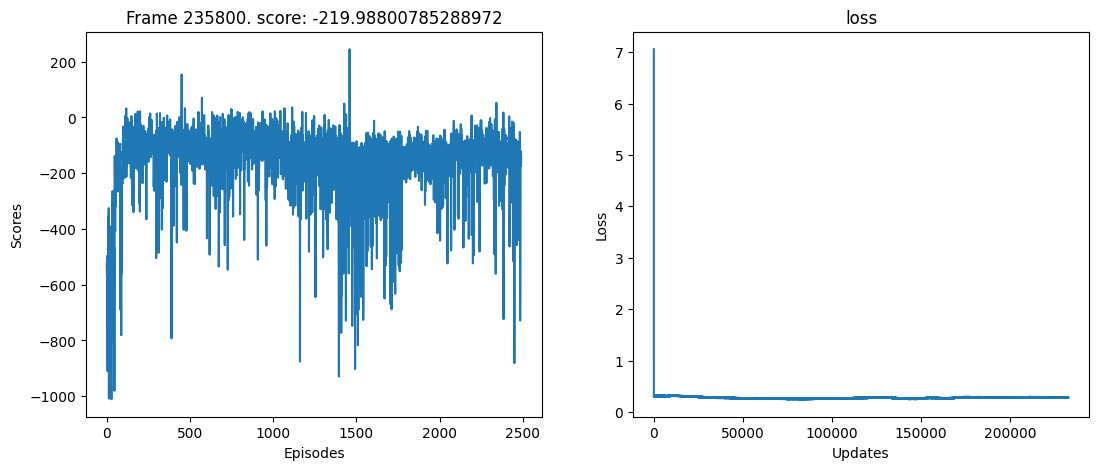

KeyboardInterrupt: 

In [11]:
agent.train(num_frames, save_path)

Test
Run agent for 1 episode

In [ ]:
video_folder = './videos/rainbow_lunar'
agent.test(video_folder)

score:  [-63.40194794432217, -367.7150162917472, -154.94828938094105, -119.60800299769969, -271.18858730445197]
Mean score:  -195.37236878383243
Std score:  109.76395076336067


Render

In [ ]:
import base64
import glob
import io
from IPython.display import HTML, display

def ipython_show_video(path):
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError('Cannot access: {}'.format(path))
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''
        <video width="400" height="400" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))

def show_latest_video(video_folder):
    """Show the latest video within the `video_folder`."""
    list_of_files = glob.glob(os.path.join(video_folder, '*.mp4'))
    latest_video = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_video)
    return latest_video

latest_video = show_latest_video(video_folder)
print("Played:", latest_video)

Played: ./videos/rainbow\rl-video-episode-4.mp4
